<a href="https://colab.research.google.com/github/nedokormysh/GB_Libraries_python_for_DS_2/blob/CourseProject/INBerezutskiy_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Подключение библиотек и загрузка данных<a class="anchor" id="load_data"></a>

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 43 kB/s 


In [2]:
import pandas as pd
import numpy as np
import pickle


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2_contingency
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler

from scipy.stats import shapiro, probplot, mannwhitneyu

Дополнительные функции

In [3]:
"""Отчет с метриками модели"""
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_displot(feature, data, title, figsize):
    """Диаграмма распределения признака со средней, медианой и модой"""
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    sns.displot(data[feature], bins=40, aspect=figsize[0], height=figsize[1], kde=True)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()

In [5]:
def show_boxplot(feature):
  """Боксплот"""
  plt.figure(figsize=(6, 4))

  sns.boxplot(x=df_train[feature], whis=1.5, orient='h')

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [10]:
TRAIN_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_train.csv'
TEST_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_test.csv'

#**Построение модели классификации**

##  Обзор обучающего датасета.

In [11]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train_base = df_train.copy()
df_train.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


Проверка на дубликаты.

In [12]:
df_train.duplicated().value_counts()

False    7500
dtype: int64

Общая информация о датасете.

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Существуют пропуски 

1.   Bankruptcies
2.   Credit_Score
3.   Years_in_current_job
4.   Annual_Income
5.   Months_since_last_delinquent



In [ ]:
# print(f'В обучающейм датафрейме {df_train.shape[0]} строк и {df_train.shape[1]} столбцов')

**Признаки датасета.**

In [ ]:
# nl = '\n'
# print(f"Названия столбцов в обучающем датафрейме: {nl}{df_train.columns}")

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [14]:
target = 'Credit Default'

num_feat = list(df_train.select_dtypes(exclude='object').columns)
nom_feat = list(df_train.select_dtypes(include='object').columns)
print(f'Числовые признаки: {num_feat}')
print(f'Номинативные признаки: {nom_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки: ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']
Номинативные признаки: ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
Целевая переменная: Credit Default


### Обзор целевой переменной

Распределение значений целевой переменной

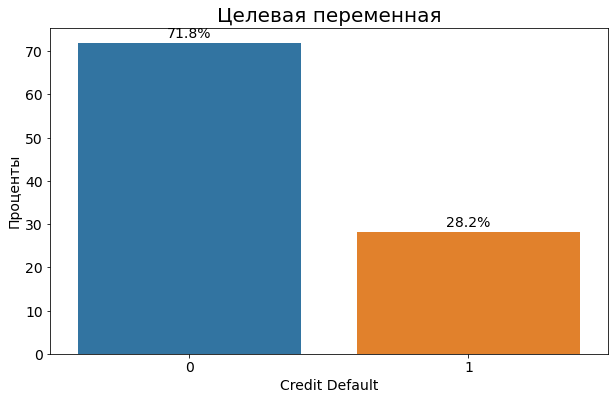

In [15]:
# нормирование на размер датасета
norm_target = (df_train['Credit Default'].value_counts(normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Целевая переменная', fontsize=20)

plt.xlabel('Credit Default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать. Определим дисбаланс целевой переменной. Будем использовать при построении модели.

In [16]:
disbalance = df_train['Credit Default'].value_counts()[0] / df_train['Credit Default'].value_counts()[1]
disbalance

2.549455750118315

Определим степень влияния признаков на целевой класс

Text(0.5, 1.0, 'Correlation with TARGET variable')

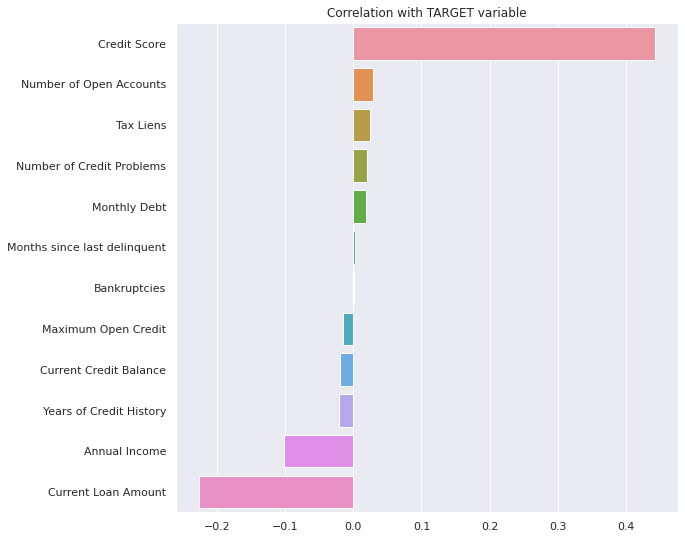

In [17]:
sns.set(font_scale=1)
corr_with_TARGET = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')

Наибольшая линейная корреляция с целевой переменной наблюдается с Credit_Score и Current_Loan_Amount.

### Номинативные признаки.

In [18]:
nl = '\n'

def nom_feat_value_counts(nom_feat):
  for el in range(0, len(nom_feat)):
    print('\033[1m' + f'Уникальные значения номинативного признака {nom_feat[el]}:{nl * 2}'
     + '\033[0m' + f'{df_train[nom_feat[el]].value_counts()}{nl}')
    print('-' * 80)

nom_feat_value_counts(nom_feat)

Уникальные значения номинативного признака Home Ownership:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Years in current job:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Purpose:

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
weddi

Заменим номинативный признак Years_in_current_job на числовые значения для удобства.

In [19]:
years_job_dict = {'< 1 year': 0,
                  '1 year': 1,
                  '2 years': 2,
                  '3 years': 3,
                  '4 years': 4,
                  '5 years': 5,
                  '6 years': 6,
                  '7 years': 7,
                  '8 years': 8,
                  '9 years': 9,
                  '10+ years': 10}

df_train['Years in current job'] = pd.Series(df_train['Years in current job'].map(years_job_dict), dtype='int8')

Признак Term принимает всего два значения. Заменим их на 0 и 1.

In [20]:
term_dict = {'Short Term': 0, 'Long Term': 1}

df_train.Term = pd.Series(df_train.Term.map(term_dict), dtype='int8')

In [21]:
target = 'Credit Default'
feat =  df_train.columns.drop(target).tolist()
num_feat = list(df_train.select_dtypes(exclude='object').columns.drop([target, 'Term', 'Years in current job']))
cat_feat = list(df_train.select_dtypes(include='object').columns)
print(f'Числовые признаки c целевой переменной: {num_feat}')
print(f'Категориальные признаки: {cat_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки c целевой переменной: ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
Категориальные признаки: ['Home Ownership', 'Purpose']
Целевая переменная: Credit Default


### Числовые признаки.

In [22]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Years in current job,7129.0,5.880348e+00,3.620092e+00,0.0,3.0,6.0,10.00,1.000000e+01
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Term,7500.0,2.592000e-01,4.382248e-01,0.0,0.0,0.0,1.00,1.000000e+00



*   Annual_Income - есть пропущенные значения
*   Years_in_current_job - есть пропущенные значения
*   Tax_Liens практически все значения - нули
*   Number of Open Accounts - возможно есть выбросы 
*   Years_of_Credit_History - есть выбросы
*   Maximum_Open_Credit - есть нулевые значения, возможно есть выбросы
*   Current_Loan_Amount - возможно есть выбросы
*   Monthly_Debt - возможно есть выбросы
*   Number_of_Credit_Problems - возможно есть выбросы, и много значений - нули
*   Months_since_last_delinquent - много пропущенных значений
*   Bankruptcies - есть пропуски
*   Credit_Score - много пропусков, корелляция с целевой переменной

**Матрица корреляции между признаками.**

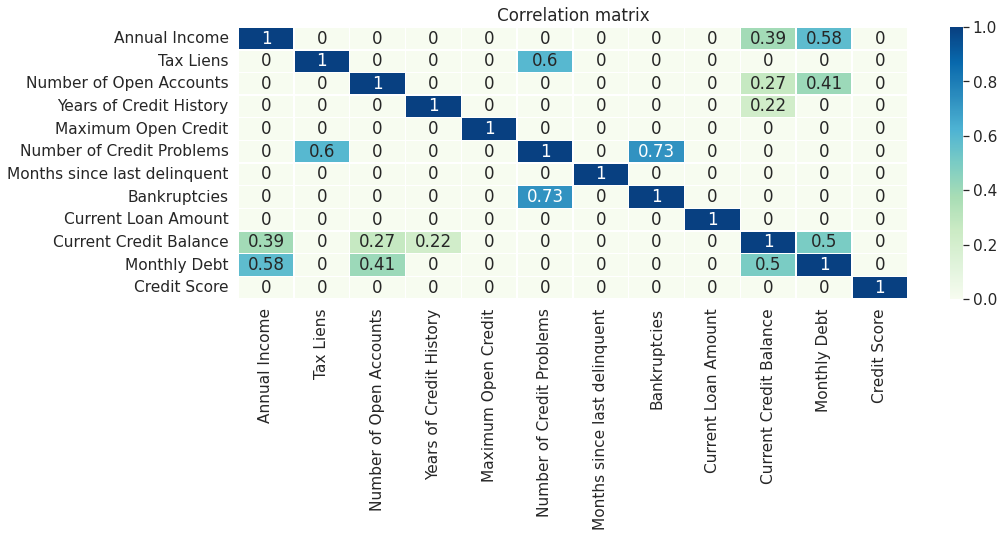

In [23]:
plt.figure(figsize=(15, 5))

sns.set(font_scale=1.4)

corr_matrix = df_train[num_feat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наблюдаются корреляции между:
*  количеством проблемных кредитов и банкротствами (Number_of_Credit_Problems и Bankruptcies) - 0.73
*  количеством проблемных кредитов и налоговыми обременениями (Number_of_Credit_Problems и Tax_lies) - 0.6
*  месячной задолженностью и годовым доходом (Annual_income и Monthly_Debt) - 0.58
*  текущим кредитным балансом и ежемесячной задолженностью (Current_Credit_Balance и Monthly_Debt) - 0.5
*  годовым доходом и текущим кредитным балансом (Annual_income и Current_Credit_Balance) - 0.39

## 2. Обработка пропусков.

Визуализируем и рассмотрим все признаки, где отсутсвуют значения.

Text(79.5, 0.5, 'Values')

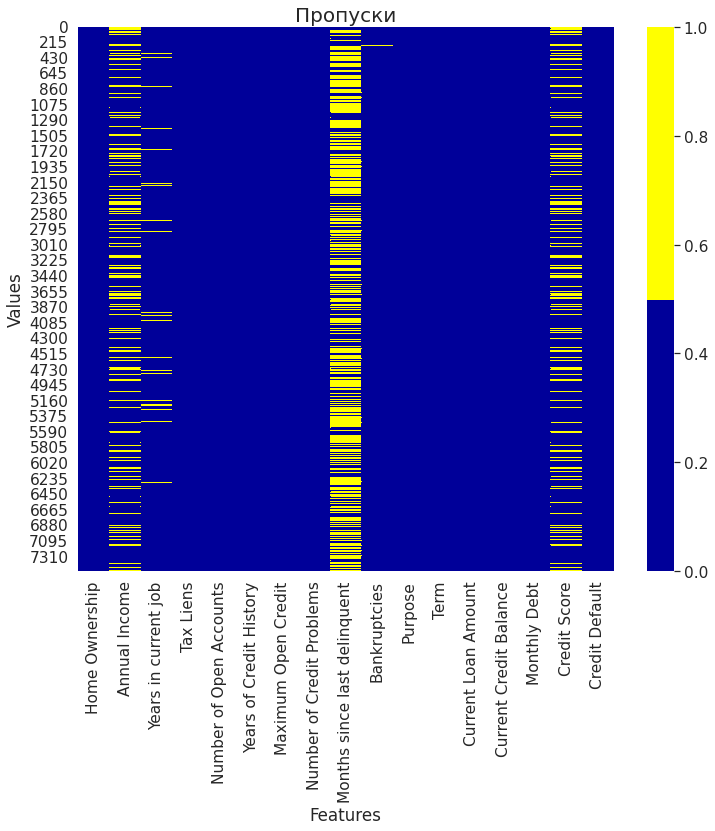

In [24]:
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные

plt.figure(figsize=(12, 10))
colours = ['#000099', '#ffff00'] 
ax = sns.heatmap(df_train[df_train.columns].isnull(), cmap=sns.color_palette(colours))

# Decorations

plt.title('Пропуски', fontsize=20)

plt.xlabel('Features')
plt.ylabel('Values')

In [ ]:
# df_train.isna().sum()

Найдём процент пропущенных значений.

In [25]:
print(f'Процент пропусков в датафрейме по столбцам\n')
for col in df_train.columns:
  have_null = df_train[col].isna().sum()
  if have_null != 0:
    print(f'{col} - {round(df_train[col].isna().sum() / df_train.shape[0]*100, 2)}%')

Процент пропусков в датафрейме по столбцам

Annual Income - 20.76%
Years in current job - 4.95%
Months since last delinquent - 54.41%
Bankruptcies - 0.19%
Credit Score - 20.76%


### Annual_Income 

In [26]:
Annual_Income_med = df_train['Annual Income'].median()
print(f'Медиана признака Annual_Income = {Annual_Income_med}')

Медиана признака Annual_Income = 1168386.0


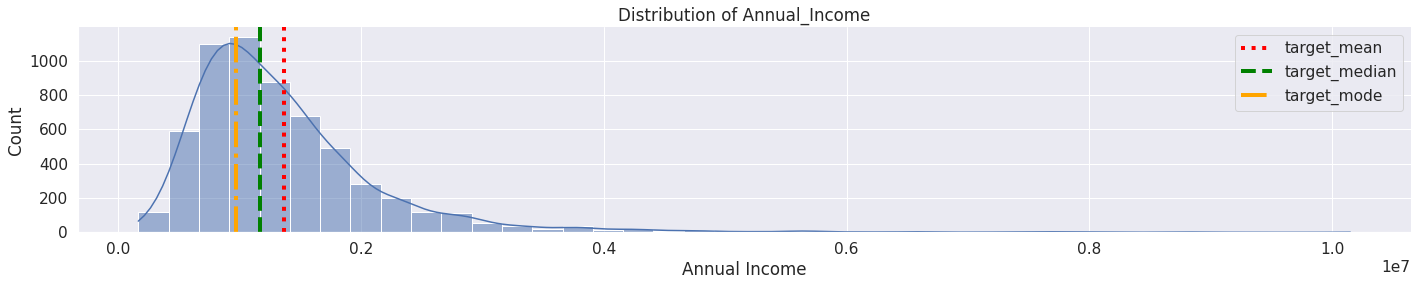

In [27]:
show_displot(feature='Annual Income', data=df_train, title='Distribution of Annual_Income', figsize=(5, 4))

Введём столбец для учёта тех строк, где были отсутствующие значения.

In [28]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
# df_train[df_train['Annual_Income_NaN'] == 1].count()

Заполним отсутствующие значения медианой.

In [29]:
df_train['Annual Income'].fillna(Annual_Income_med, inplace=True)
df_train['Annual Income'].isna().sum()

0

### Years_in_current_job

Заполним пропуски количества лет на работе на значение моды.

In [30]:
df_train['Years in current job NaN'] = 0
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job NaN'] = 1

In [31]:
Years_in_current_job_mod = df_train['Years in current job'].mode()[0]
print(f'Мода признака Years_in_current_job = {Years_in_current_job_mod}')

df_train['Years in current job'].fillna(Years_in_current_job_mod, inplace=True)
# print(df_train.Years_in_current_job.isna().sum())

Мода признака Years_in_current_job = 10.0


### Months_since_last_delinquent

Линейная корреляция с целевой переменной мала. Удалим этот признак.

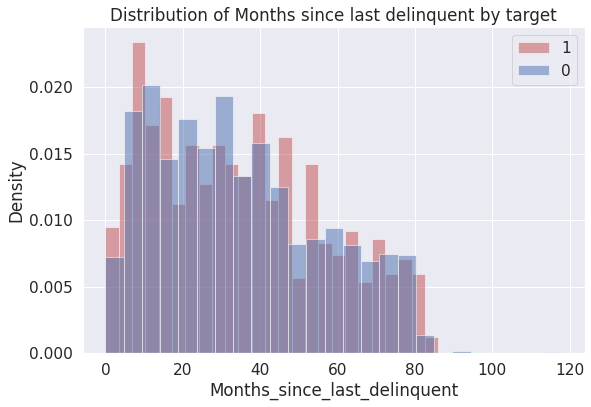

In [32]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit Default'] == 1, 'Months since last delinquent'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit Default'] == 0, 'Months since last delinquent'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Months_since_last_delinquent')
plt.ylabel('Density')
plt.title('Distribution of Months since last delinquent by target')
plt.legend()
plt.show()

Признак не оказывает сильного влияния на целевую переменную.

### Bankruptcies

Предположим в отсутствующих значениях банкротств, то их просто нет. И заполним значения 0.

In [33]:
df_train['Bankruptcies NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
df_train['Bankruptcies'].fillna(0 , inplace=True)
# df_train['Bankruptcies'].isna().sum()

### Credit_Score

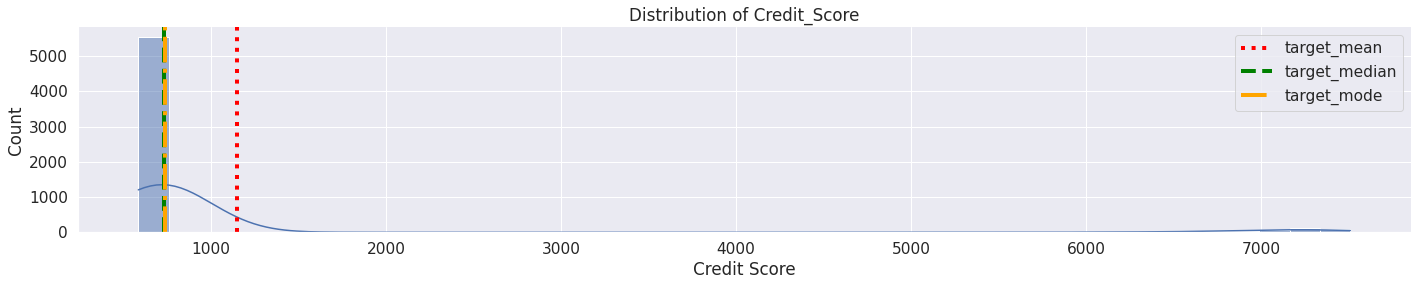

In [34]:
show_displot(feature='Credit Score', data=df_train, title='Distribution of Credit_Score', figsize=(5, 4))

Заполним отсутствующие значения Credit_Score модой.

In [35]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1

Credit_Score_mode = df_train['Credit Score'].mode()[0]
Credit_Score_mode

df_train['Credit Score'].fillna(Credit_Score_mode, inplace=True)
df_train['Credit Score'].isna().sum()

0

## Обработка выбросов.

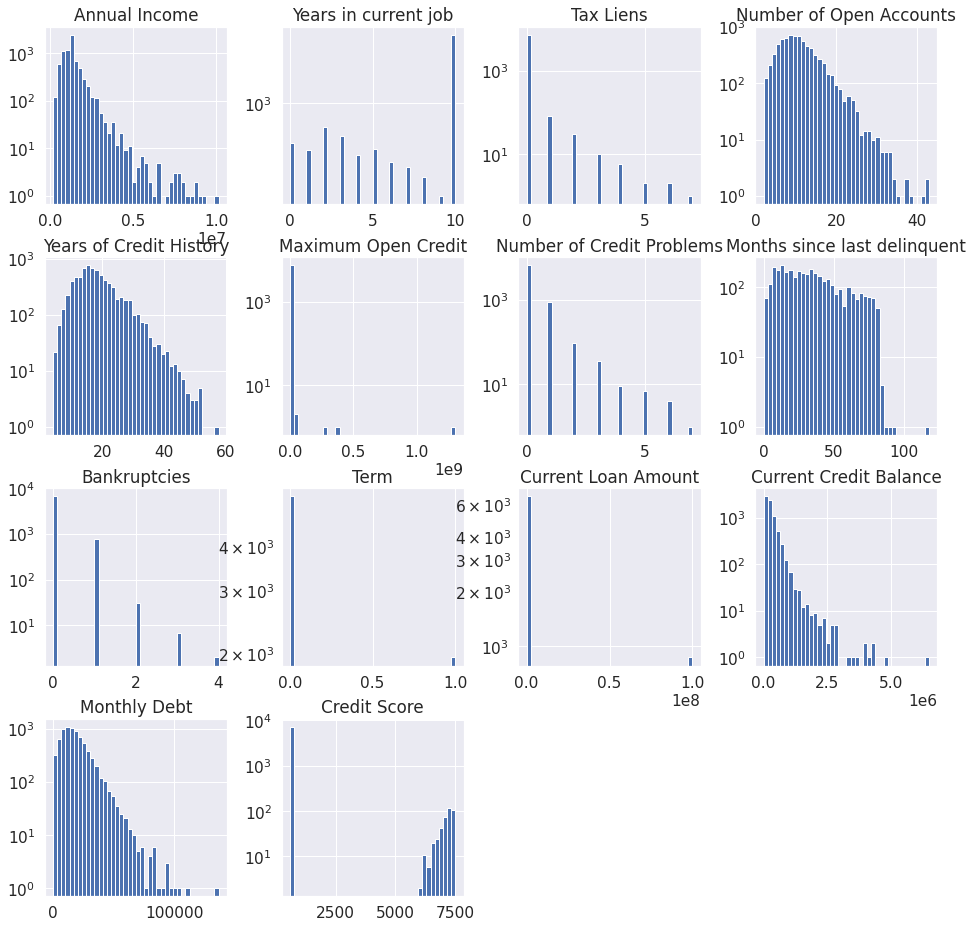

In [36]:
df_train[feat].hist(bins=40, figsize=(16, 16), log = True)

plt.show()

### Current_Loan_Amount

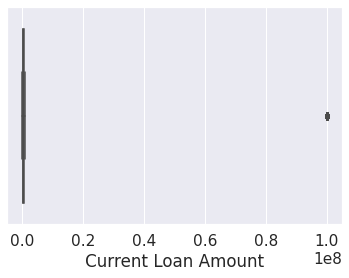

In [37]:
show_boxplot(feature='Current Loan Amount')

In [38]:
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'].value_counts()

99999999.0    870
Name: Current Loan Amount, dtype: int64

Наблюдается 870 выбросов со значением 99999999.0. 

Посмотрим на распределение значений в разрезе целевой переменной.

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


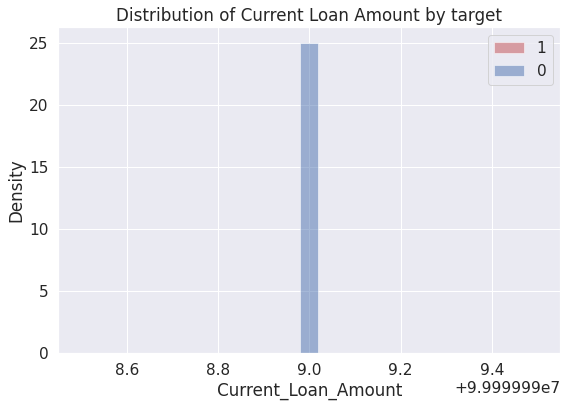

In [39]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current_Loan_Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

Выбросные значения 99999999.0 имеют значения 0 колонки Credit Default, вероятно, что пользователи с такими значениями не допустили просрочки по кредиту, при этом какой-то кредит возможно есть.

In [40]:
df_train['Current Loan Amount'].quantile(.95)

99999999.0

Заполним медианой. Хотя возможен вариант заполнения нулём.

In [41]:
df_train['Current Loan Amount Outlier'] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

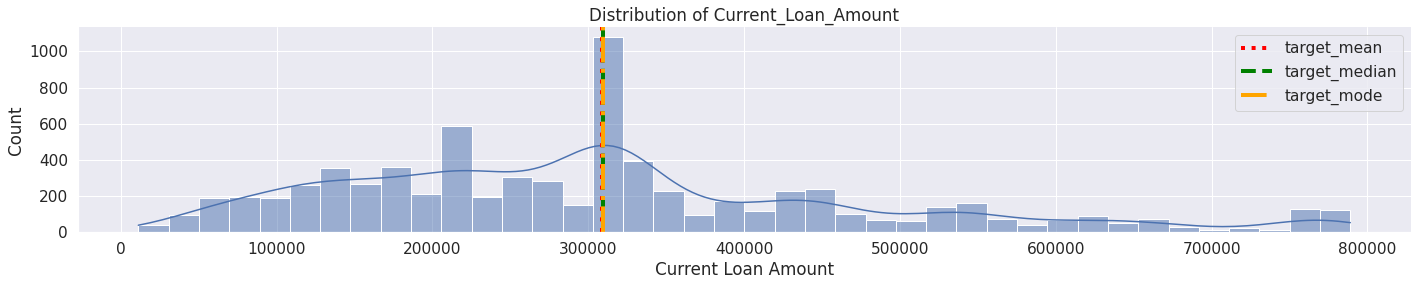

In [42]:
show_displot(feature='Current Loan Amount', data=df_train, title='Distribution of Current_Loan_Amount', figsize=(5, 4))

### Maximum_Open_Credit

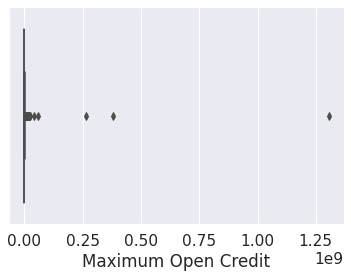

In [43]:
show_boxplot(feature='Maximum Open Credit')

В Current_Loan_Amount максимальным значением было 99999999.0. Примем его за максимум.

In [44]:
max_credit = 99999999.0

In [45]:
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'].count()

3

In [46]:
df_train['Maximum Open Credit Outlier'] = 0
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], 'Maximum Open Credit Outlier'] = 1

df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

Также есть значения, где максимальный кредит меньше размера текущего кредита. Заменим такие значения на Current_Loan_Amount

In [47]:
df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], ['Maximum Open Credit', 'Current Loan Amount']].head()

,Maximum Open Credit,Current Loan Amount
8,0.0,129734.0
9,511302.0,572880.0
18,387222.0,553586.0
19,199078.0,309672.0
22,288442.0,309573.0


In [48]:
for i in range(0, len(df_train['Maximum Open Credit'].values)):
            if df_train['Maximum Open Credit'].values[i] <= df_train['Current Loan Amount'].values[i]:
                df_train['Maximum Open Credit'].values[i] = df_train['Current Loan Amount'].values[i]

### Credit_Score

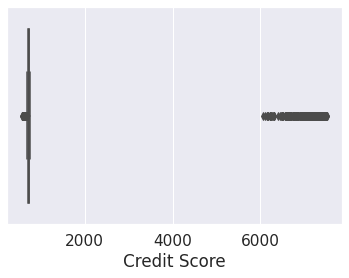

In [49]:
show_boxplot('Credit Score')

In [50]:
df_train[df_train['Credit Score'] <= 850]['Credit Score'].count()

7100

In [51]:
df_train[df_train['Credit Score'] >= 1000]['Credit Score'].count()

400

Есть 400 значений в диапазоне [6000, 8000], которые на порядок больше остальных 7100 в диапазоне [500, 750]. Предположим, что это ошибка и разделим значения более 850 на 10.

In [52]:
df_train['Credit Score Outlier'] = 0
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] / 10

### Home_Ownership

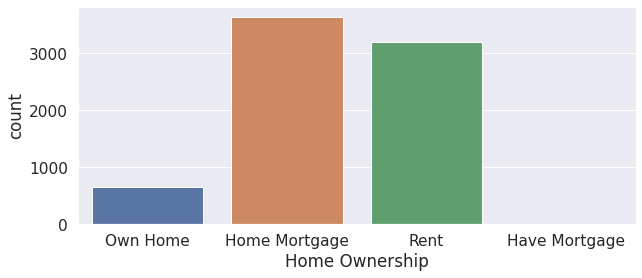

In [53]:
# Prepare Data
plt.figure(figsize=(10, 4))

# Draw plot
sns.countplot(x=df_train['Home Ownership'])

Home_Ownership - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode().

Have Mortgage - это просто наличие ипотеки. Также как и Home mortgage. Заменим значения на Home mortgage.

In [54]:
df_train[df_train['Home Ownership'] == 'Have Mortgage']['Home Ownership'].count()

12

In [55]:
Home_Ownership_mod = df_train['Home Ownership'].mode()[0]
print(f'Мода признака Home_Ownership = {Home_Ownership_mod}')

Мода признака Home_Ownership = Home Mortgage


In [56]:
df_train['Home Ownership Outlier'] = 0
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership Outlier'] = 1
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = Home_Ownership_mod

### Years_of_Credit_History

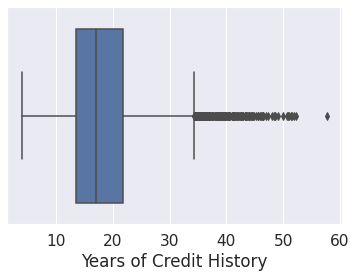

In [57]:
show_boxplot('Years of Credit History')

In [ ]:
# df_train.Years_of_Credit_History.quantile(0.995)

In [58]:
df_train[df_train['Years of Credit History'] > 50]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,Annual Income NaN,Years in current job NaN,Bankruptcies NaN,Credit Score NaN,Current Loan Amount Outlier,Maximum Open Credit Outlier,Credit Score Outlier,Home Ownership Outlier
247,Home Mortgage,1893426.0,10.0,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,...,654.0,1,0,1,0,0,0,0,0,0
476,Home Mortgage,1076768.0,10.0,0.0,14.0,57.7,558360.0,0.0,24.0,0.0,...,667.0,1,0,1,0,0,0,1,0,0
3091,Rent,582141.0,10.0,0.0,7.0,50.9,487498.0,0.0,NaN,0.0,...,750.0,0,0,1,0,0,1,0,0,0
3628,Own Home,376314.0,10.0,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,...,720.0,0,0,1,0,0,0,0,0,0
4301,Home Mortgage,1168386.0,10.0,0.0,19.0,51.9,1602524.0,0.0,17.0,0.0,...,740.0,0,1,1,0,1,0,0,0,0
4716,Rent,1168386.0,10.0,0.0,5.0,51.5,614614.0,0.0,14.0,0.0,...,740.0,1,1,1,0,1,0,1,0,0
5673,Home Mortgage,949810.0,10.0,0.0,15.0,50.6,1180388.0,0.0,71.0,0.0,...,727.0,0,0,0,0,0,0,0,0,0
7251,Home Mortgage,1168386.0,10.0,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,...,740.0,1,1,0,0,1,0,0,0,0


In [59]:
Years_of_Credit_History_mod = df_train['Years of Credit History'].mode()[0]
print(f'Мода Years_of_Credit_History = {Years_of_Credit_History_mod}')

df_train['Years of Credit History Outlier'] = 0
df_train.loc[df_train['Years of Credit History'] > 50, 'Years of Credit History Outlier'] = 1
df_train.loc[df_train['Years of Credit History'] > 50, 'Years of Credit History'] = Years_of_Credit_History_mod

Мода Years_of_Credit_History = 15.0


### Monthly_Debt

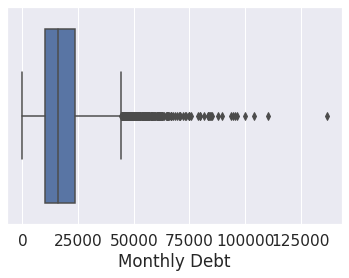

In [60]:
show_boxplot('Monthly Debt')

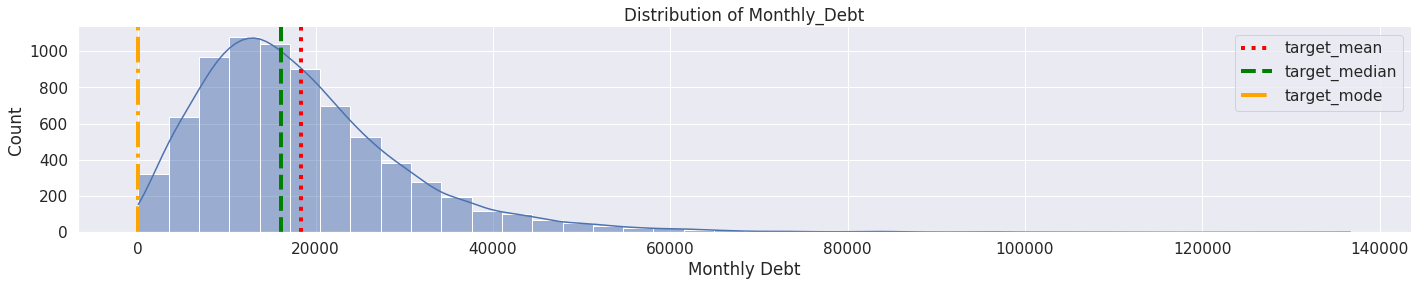

In [61]:
show_displot(feature='Monthly Debt', data=df_train, title='Distribution of Monthly_Debt', figsize=(5, 4))

In [62]:
df_train['Monthly Debt'].quantile(0.999)

91718.35100000429

In [63]:
Monthly_Debt_med = df_train['Monthly Debt'].median()
# print(Monthly_Debt_med)

df_train['Monthly_Debt_Outlier'] = 0
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(0.999), 'Monthly Debt Outlier'] = 1
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(0.999), 'Monthly Debt'] = Monthly_Debt_med

## EDA

### Purpose 

**Оценка признака "Purpose" в разрезе целевой переменной**

В данном признаке слишком много переменных, попробуем их сократить.

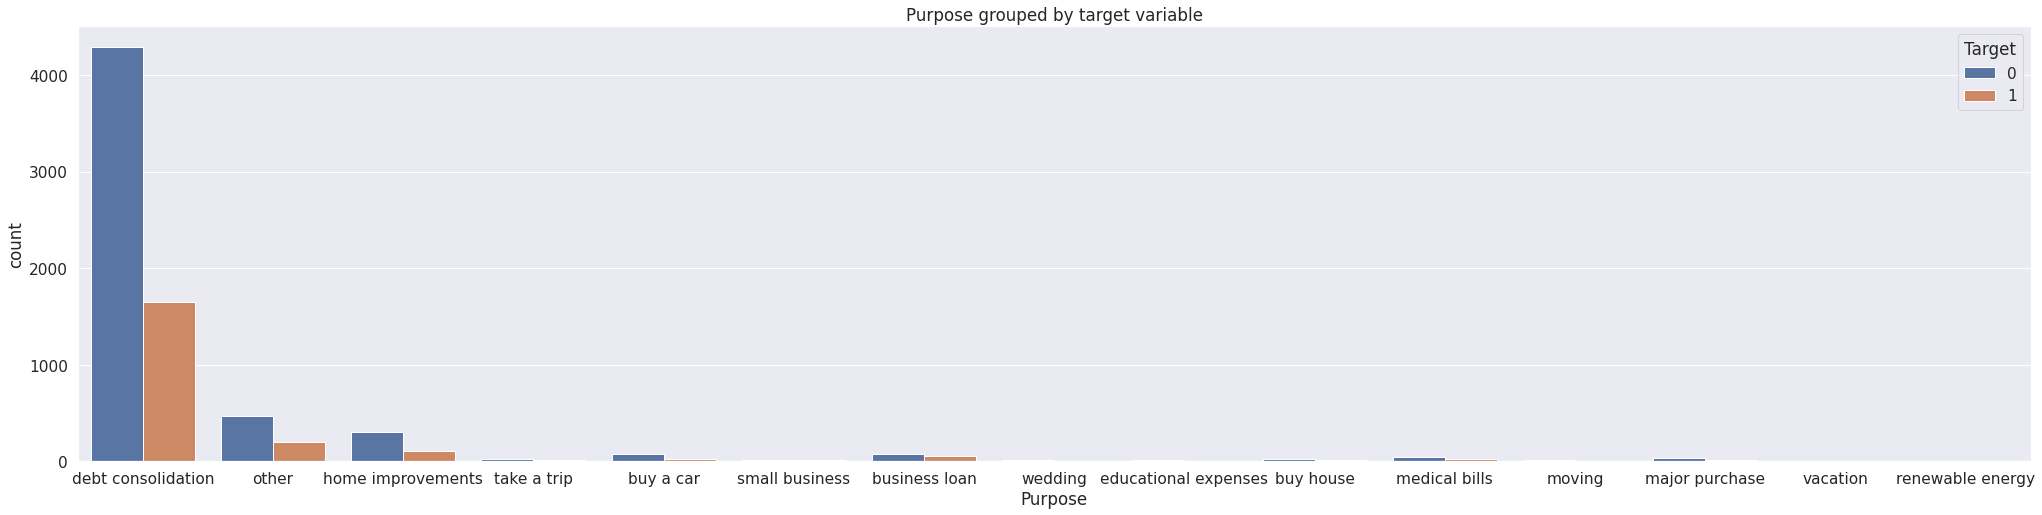

In [64]:
plt.figure(figsize=(35, 8))

sns.countplot(x="Purpose", hue=target, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [65]:
df_train_base['ID'] = df_train_base.index

purpose_target_all = df_train_base[['ID', 'Purpose', 'Credit Default']]

table = purpose_target_all.pivot_table(columns='Credit Default', index='Purpose', values='ID', aggfunc='count')
table.columns.to_list()
table['devide'] = table[0] / table[1]
table

Credit Default,0,1,devide
Purpose,,,
business loan,74.0,55.0,1.345455
buy a car,72.0,24.0,3.000000
buy house,25.0,9.0,2.777778
debt consolidation,4290.0,1654.0,2.593712
educational expenses,9.0,1.0,9.000000
home improvements,304.0,108.0,2.814815
major purchase,31.0,9.0,3.444444
medical bills,49.0,22.0,2.227273
moving,9.0,2.0,4.500000


**Наблюдение**

Проверим гипотезу о согласованности частот в Purpose, используя хи-критерий Пирсона.
Объединим значения по логическим группам и долям в разрезе целевой переменной, рассчитаем таблицы частот и проверим гипотезу для каждой из групп значений

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты выбранных категорий признака Purpose в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [66]:
business = df_train['Purpose'].isin(['business loan', 'small business'])
purchase = df_train['Purpose'].isin(['buy a car', 'buy house', 'major purchase'])
entertainment = df_train['Purpose'].isin(['vacation', 'wedding', 'take a trip'])
needs = df_train['Purpose'].isin(['debt consolidation', 'home improvements', 'medical bills', 'moving'])
random = df_train['Purpose'].isin(['educational expenses', 'renewable energy', 'other'])

In [67]:
purpose_business_and_target = df_train_base.loc[business, ['ID', 'Purpose', 'Credit Default']]
purpose_purchase_and_target = df_train_base.loc[purchase, ['ID', 'Purpose', 'Credit Default']]
purpose_entertainment_and_target = df_train_base.loc[entertainment, ['ID', 'Purpose', 'Credit Default']]
purpose_needs_and_target = df_train_base.loc[needs, ['ID', 'Purpose', 'Credit Default']]
purpose_random_and_target = df_train_base.loc[random, ['ID', 'Purpose', 'Credit Default']]

In [68]:
table_purpose_business_cut = purpose_business_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_business_cut

Credit Default,0,1
Purpose,,
business loan,74,55
small business,12,14


In [69]:
chi2, p, dof, expected = chi2_contingency(table_purpose_business_cut, correction=False)
p

0.29404148780405304

In [70]:
table_purpose_purchase_cut = purpose_purchase_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_purchase_cut

Credit Default,0,1
Purpose,,
buy a car,72,24
buy house,25,9
major purchase,31,9


In [71]:
chi2, p, dof, expected = chi2_contingency(table_purpose_purchase_cut, correction=False)
p

0.9203439570048738

In [72]:
table_purpose_entertainment_cut = purpose_entertainment_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_entertainment_cut

Credit Default,0,1
Purpose,,
take a trip,27,10
vacation,6,2
wedding,11,4


In [73]:
chi2, p, dof, expected = chi2_contingency(table_purpose_entertainment_cut, correction=False)
p

0.9931135019442172

In [74]:
table_purpose_needs_cut = purpose_needs_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_needs_cut

Credit Default,0,1
Purpose,,
debt consolidation,4290,1654
home improvements,304,108
medical bills,49,22
moving,9,2


In [75]:
chi2, p, dof, expected = chi2_contingency(table_purpose_needs_cut, correction=False)
p

0.7112886942093957

In [ ]:
# df_train_base['Purpose'].isna().sum()

In [ ]:
# table_purpose_random_cut = purpose_random_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
# table_purpose_random_cut

В выбранных категориях P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [76]:
purpose_change_dict = {'business loan': 'business',
                       'small business': 'business',
                       'buy a car': 'purchase',
                       'buy house': 'purchase',
                       'major purchase': 'purchase',
                       'vacation': 'entertainment',
                       'wedding': 'entertainment',
                       'take a trip': 'entertainment',
                       'debt consolidation': 'needs',
                       'home improvements': 'needs',
                       'medical bills': 'needs',
                       'moving': 'needs',
                       'educational expenses':'educational expenses',
                       'other': 'other',
                       'renewable energy': 'renewable energy'}

df_train['Purpose'] = pd.Series(df_train.Purpose.map(purpose_change_dict))

### Years_in_current_job

Посмотрим на признак 'Years in current job' в разрезе целевой переменной

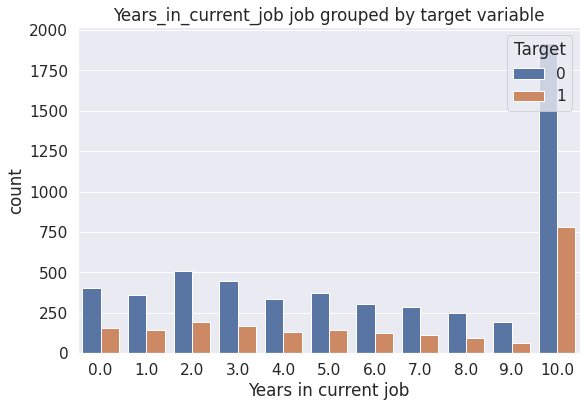

In [77]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Years in current job', hue='Credit Default', data=df_train)
plt.title('Years_in_current_job job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [78]:
df_train.groupby('Years in current job')['Credit Default'].mean().sort_values()

Years in current job
9.0     0.250965
8.0     0.271386
2.0     0.273759
3.0     0.274194
4.0     0.279318
7.0     0.280303
5.0     0.281008
1.0     0.281746
0.0     0.282416
10.0    0.288938
6.0     0.291080
Name: Credit Default, dtype: float64

In [79]:
df_train['Years in current job'].value_counts()

10.0    2703
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

Years_in_current_job - Создадим разбивку по категориям для лет, проведённых на работе в разделе новых признаков.

### Number of Credit Problems, Bankruptcies

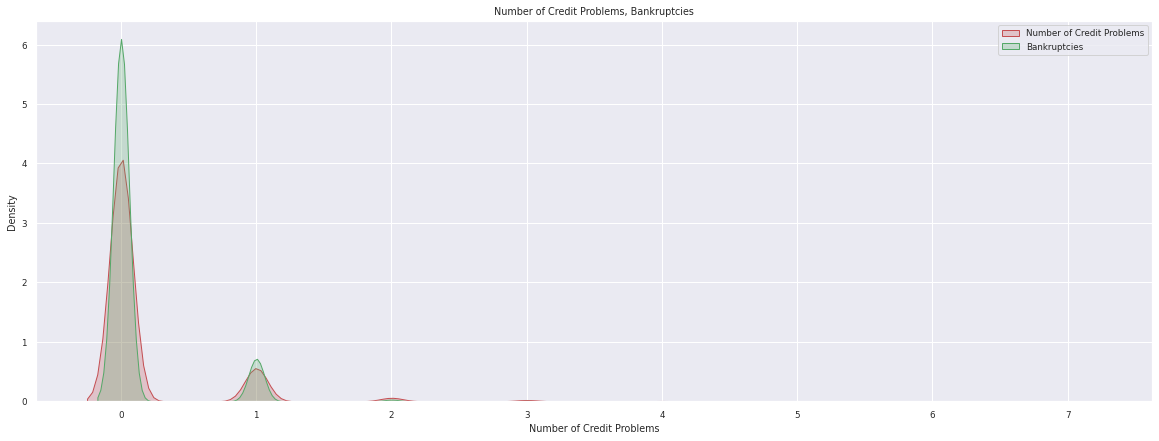

In [80]:
# train dataset
plt.figure(figsize=(20, 7))
sns.set(font_scale=0.8)
sns.kdeplot(df_train['Number of Credit Problems'], shade=True, label='Number of Credit Problems', color='r')
sns.kdeplot(df_train['Bankruptcies'].fillna(0), shade=True, label='Bankruptcies', color='g')
plt.legend()
plt.title('Number of Credit Problems, Bankruptcies' )
plt.show()

**Наблюдение**

Графики выглядят похожими. 

**Гипотеза**

Нулевая гипотеза: средние значения в двух независимых выборках равны

Альтернативная гипотеза: средние значения в двух независимых выборках различаются

Критерий: критерий Манна-Уитни

Уровень значимости : 0.05

In [81]:
mannwhitneyu(df_train['Number of Credit Problems'], df_train['Bankruptcies'])

MannwhitneyuResult(statistic=27314833.0, pvalue=4.362140868330774e-08)

Значение p-value оказалось меньше, чем уровень значимости $\alpha$, соответственно. Мы не можем принять нулевую гипотезу

## Добавление новых признаков

### Категории стажа Years_in_current_cat

In [82]:
df_train['Years in current Cat'] = df_train['Years in current job'].map({0: 0, 
                                                                         1: 0, 
                                                                         2: 0, 
                                                                         3: 0, 
                                                                         4: 1, 
                                                                         5: 1, 
                                                                         5: 1, 
                                                                         7: 2,
                                                                         8: 2,
                                                                         9: 2,
                                                                         10: 3})

### Ежемесячный доход Monthly_Income

In [83]:
df_train['Monthly Income'] = df_train['Annual Income'] / 12

### Разность ежемесячного дохода и ежемесячной задолженности

In [84]:
df_train['Monthly Inc Debt Diff'] = df_train['Monthly Income'] - df_train['Monthly Debt']

### Категория кредитного скоринга Credit_Score_category

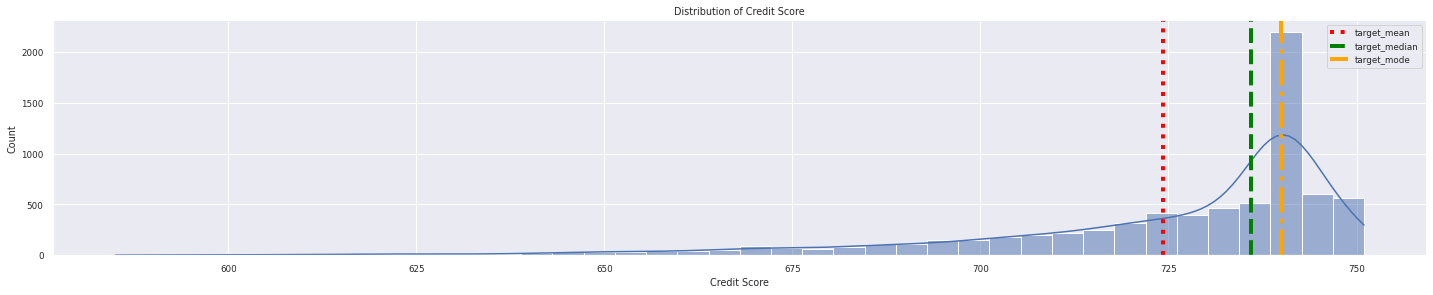

In [85]:
show_displot(feature='Credit Score', data=df_train, title='Distribution of Credit Score', figsize=(5, 4))

In [86]:
bins_credit_score = [625, 675, 700, 725, 735, 750]
df_train['Credit Score Cat'] = pd.cut(df_train['Credit Score'], bins=bins_credit_score, labels=False)
df_train['Credit Score Cat'].fillna(-1, inplace=True)

In [ ]:
# df_train.loc[df_train['Credit Score'] <= 625, ['Credit Score', 'Credit Score Cat']]

### Разность между долгом и зарплатой

In [87]:
df_train['Current Loan and Monthly Income Diff'] = df_train['Current Loan Amount'] - df_train['Monthly Income']

# Классы с обработкой данных

## Preprocessing

In [88]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes=None
        self.max_score = 850
        self.max_credit = 99999999.0
        self.credit_history_mod = 15.0
        self.ownership = 'Home Mortgage'
        self.monthly_debt = 16000
        self.purpose_change_dict = {'business loan': 'business',
                                    'small business': 'business',
                                    'buy a car': 'purchase',
                                    'buy house': 'purchase',
                                    'major purchase': 'purchase',
                                    'vacation': 'entertainment',
                                    'wedding': 'entertainment',
                                    'take a trip': 'entertainment',
                                    'debt consolidation': 'needs',
                                    'home improvements': 'needs',
                                    'medical bills': 'needs',
                                    'moving': 'needs',
                                    'educational expenses':'educational expenses',
                                    'other': 'other',
                                    'renewable energy': 'renewable energy'}
 

        self.years_job_dict = {'< 1 year': 0,
                                 '1 year': 1,
                                 '2 years': 2,
                                 '3 years': 3,
                                 '4 years': 4,
                                 '5 years': 5,
                                 '6 years': 6,
                                 '7 years': 7,
                                 '8 years': 8,
                                 '9 years': 9,
                                 '10+ years': 10}

        
    def fit(self, X):
        """Сохранение статистик"""

        # X.columns = [x.replace(" ", "_") for x in X.columns]
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""

        # Purpose
        X['Purpose'] = pd.Series(X['Purpose'].map(self.purpose_change_dict))

        
        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1

        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.modes['Credit Score'], inplace = True)

     
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']


        # Maximum Open Credit
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] < X['Current Loan Amount'], 'Maximum Open Credit Outlier'] = 1

        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit'] = self.max_credit

        for i in range(0, len(X['Maximum Open Credit'].values)):
            if X['Maximum Open Credit'].values[i] <= X['Current Loan Amount'].values[i]:
                X['Maximum Open Credit'].values[i] = X['Current Loan Amount'].values[i]


        # Annual Income
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)

        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Years_in_current_job   
        X['Years in current job'] = pd.Series(X['Years in current job'].map(self.years_job_dict), dtype='int8')
          
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)


        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(0, inplace=True)


        # Home_Ownership
        X['Home Ownership Outlier'] = 0
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership Outlier'] = 1
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = self.ownership


        # Years_of_Credit_History
        X['Years of Credit History Outlier'] = 0
        X.loc[X['Years of Credit History'] > 50, 'Years of Credit History Outlier'] = 1
        X.loc[X['Years of Credit History'] > 50, 'Years of Credit History'] = self.credit_history_mod

        
        # Term
        X['Term'] = X['Term'].map({'Short Term': 0, 'Long Term': 1}).astype(int)


        X['Monthly Debt Outlier'] = 0
        X.loc[X['Monthly Debt'] > 92000, 'Monthly Debt Outlier'] = 1
        X.loc[X['Monthly Debt'] > 92000, 'Monthly Debt'] = self.monthly_debt

        # Home Ownership, Purpose
        for cat_colname in X.select_dtypes(include='object'):
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
        
                
        X.fillna(self.medians, inplace=True)
        
        return X

## FeatureGenerator

In [89]:
class FeatureGenerator:
    """Генерация новых фич"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # # Term          
        # X.Term = pd.Series(X['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype='int8')


        # Years in current job

        X['Years in current Cat'] = X['Years in current job'].map({0: 0, 
                                                                   1: 0,
                                                                   2: 0,
                                                                   3: 0,
                                                                   4: 1,
                                                                   5: 1,
                                                                   6: 1,
                                                                   7: 2,
                                                                   8: 2,
                                                                   9: 2,
                                                                   10: 3})

        
        # Credit Score
        X = self.credit_score_to_cat(X)


        # Monthly_Income
        X['Monthly Income'] = X['Annual Income'] / 12


        # Monthly_Inc_Debt_Diff
        X['Monthly Inc Debt Diff'] = X['Monthly Income'] - X['Monthly Debt']


        # Current_Loan_and_Monthly_Income_Diff
        X['Current Loan and Monthly Income Diff'] = X['Current Loan Amount'] - X['Monthly Income']

        
        return X
    
    def credit_score_to_cat(self, X):
        bins_credit_score = [625, 675, 700, 725, 735, 750]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins_credit_score, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

# Создание модели

## Отбор признаков

In [90]:
feature_names = [ 'Home Ownership', 'Annual Income', 'Years in current job',
 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
 'Monthly Debt', 'Credit Score']      

new_feature_names = [ 'Credit Score Outlier', 'Credit Score NaN',
 'Current Loan Amount Outlier', 'Maximum Open Credit Outlier',
 'Annual Income NaN', 'Years in current job NaN', 'Bankruptcies NaN',
 'Home Ownership Outlier', 'Years of Credit History Outlier',
 'Monthly Debt Outlier', 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_business',
 'Purpose_educational expenses', 'Purpose_entertainment', 'Purpose_needs',
 'Purpose_other', 'Purpose_purchase', 'Purpose_renewable energy',
 'Years in current Cat', 'Credit Score Cat', 'Monthly Income',
 'Monthly Inc Debt Diff', 'Current Loan and Monthly Income Diff']

all_feat = ['Home Ownership', 'Annual Income', 'Years in current job',
 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
 'Monthly Debt', 'Credit Score', 'Credit Default', 'Credit Score Outlier',
 'Credit Score NaN', 'Current Loan Amount Outlier',
 'Maximum Open Credit Outlier', 'Annual Income NaN', 'Years in current job NaN',
 'Bankruptcies NaN', 'Home Ownership Outlier', 'Years of Credit History Outlier',
 'Monthly Debt Outlier', 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_business',
 'Purpose_educational expenses', 'Purpose_entertainment', 'Purpose_needs',
 'Purpose_other', 'Purpose_purchase', 'Purpose_renewable energy',
 'Years in current Cat', 'Credit Score Cat', 'Monthly Income',
 'Monthly Inc Debt Diff', 'Current Loan and Monthly Income Diff']

    
target_name = 'Credit Default'

Применяем наши классы обработки с нуля к датафрейму.

In [94]:
df_prep = pd.read_csv(TRAIN_DATASET_PATH)

# df_prep.columns.to_list()

preprocessor = DataPreprocessing()
preprocessor.fit(df_prep)

df_prep = preprocessor.transform(df_prep)

# df_prep.columns.to_list()

features_gen = FeatureGenerator()
features_gen.fit(df_prep)
features_gen.transform(df_prep)

df_prep.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        7500 non-null   object 
 1   Annual Income                         7500 non-null   float64
 2   Years in current job                  7500 non-null   int8   
 3   Tax Liens                             7500 non-null   float64
 4   Number of Open Accounts               7500 non-null   float64
 5   Years of Credit History               7500 non-null   float64
 6   Maximum Open Credit                   7500 non-null   float64
 7   Number of Credit Problems             7500 non-null   float64
 8   Bankruptcies                          7500 non-null   float64
 9   Purpose                               7500 non-null   object 
 10  Term                                  7500 non-null   int64  
 11  Current Loan Amou

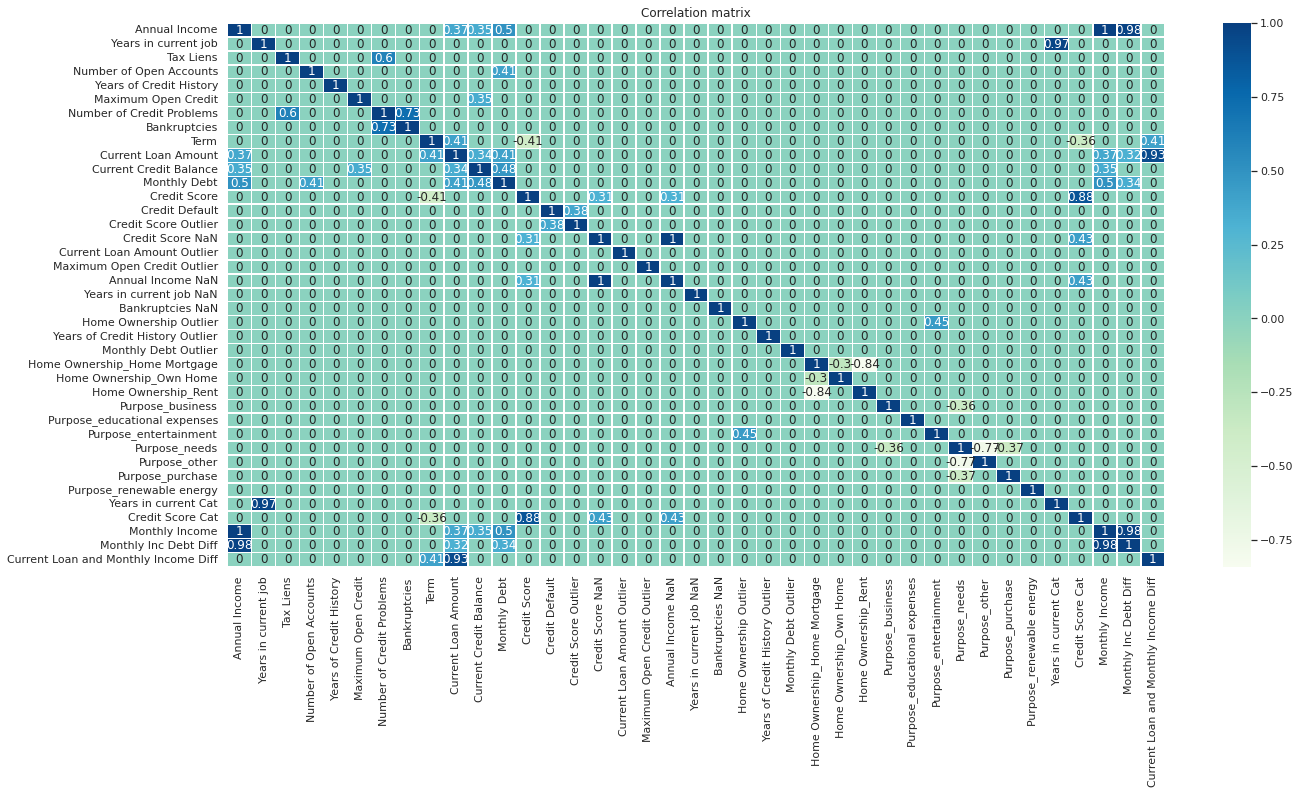

In [95]:
plt.figure(figsize=(21, 10))

sns.set(font_scale=1)

corr_matrix = df_prep[all_feat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Отберём признаки

In [96]:
feature_names = [ 
# 'Home Ownership',
 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
#  'Years of Credit History',
 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
#  'Purpose',
 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']      


new_feature_names = [ 
  'Credit Score Outlier', 'Credit Score NaN',
#  'Current Loan Amount Outlier',
#  'Maximum Open Credit Outlier',
  'Annual Income NaN',
#  'Years in current job NaN',
#  'Bankruptcies NaN',
  'Home Ownership Outlier',
#  'Years of Credit History Outlier',
#  'Monthly Debt Outlier',
  'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_business',
#  'Purpose_educational expenses',
  'Purpose_entertainment', 'Purpose_needs', 'Purpose_other', 'Purpose_purchase',
#  'Purpose_renewable energy',
  'Years in current Cat', 'Credit Score Cat', 'Monthly Income', 'Monthly Inc Debt Diff', 'Current Loan and Monthly Income Diff']

cat_feature_names = [ 'Home Ownership', 'Purpose' ]

target_name = 'Credit Default'

In [ ]:
# for colname in cat_feature_names:
#     df_train[colname] = pd.Categorical(df_train[colname])
    
# df_train[cat_feature_names].dtypes

In [97]:
num_feature_names = ['Annual Income', 'Years in current job', 'Term', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'] 

In [98]:
SELECTED_FEATURE_NAMES = num_feature_names + new_feature_names

## Нормализация данных

In [99]:
scaler = StandardScaler()

df_norm = df_prep.copy()
df_norm[num_feature_names] = scaler.fit_transform(df_norm[num_feature_names])

df = df_norm.copy()

## Разбиение на train и valid

Разобьём на обучающий и валидационный, чтобы не путать с тестовым датафреймом.

In [109]:
X = df[SELECTED_FEATURE_NAMES]
y = df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

## Балансировка признаков

### Over

In [135]:
# def balance_df_by_target_over(df, target_name):

#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

#     for i in range(disbalance_coeff):
#         sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
#         df = df.append(sample, ignore_index=True)

#     return df.sample(frac=1) 

In [134]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced_over = balance_df_by_target_over(df_for_balancing, target_name)
    
# df_balanced_over[target_name].value_counts()

In [112]:
# X_train_b_over = df_balanced_over.drop(columns=target_name)
# y_train_b_over = df_balanced_over[target_name]

### Tomek

In [113]:
# def balance_df_by_target_tomek(df, target_name):

#     from imblearn.under_sampling import TomekLinks
#     tl = TomekLinks()
#     X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
#     df = pd.concat([X_tomek, y_tomek], axis=1)

#     return df.sample(frac=1)

In [136]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced_tomek = balance_df_by_target_tomek(df_for_balancing, target_name)
    
# df_balanced_tomek[target_name].value_counts()

In [115]:
# X_train_b_tomek = df_balanced_tomek.drop(columns=target_name)
# y_train_b_tomek = df_balanced_tomek[target_name]

### Smote

In [116]:
# def balance_df_by_target_smote(df, target_name):

#     from imblearn.over_sampling import SMOTE
#     smote = SMOTE()
#     X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
#     df = pd.concat([X_smote, y_smote], axis=1)

#     return df.sample(frac=1)

In [137]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced_smote = balance_df_by_target_smote(df_for_balancing, target_name)
    
# df_balanced_smote[target_name].value_counts()

In [138]:
# X_train_b_smote = df_balanced_smote.drop(columns=target_name)
# y_train_b_smote = df_balanced_smote[target_name]

Результаты балансировки были использованы ниже в выбранной модели (Catboost). Но получить значения лучше, чем встроенная балансировка классов в Catboost не удалось

# **Построение и оценка базовых моделей**


### Выбор модели

In [122]:
# model_xgb = xgb.XGBClassifier(random_state=21)
# model_xgb.fit(X_train, y_train)

# y_train_pred = model_xgb.predict(X_train)
# y_test_pred = model_xgb.predict(X_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

In [123]:
# model_lgbm = lgb.LGBMClassifier(random_state=21)
# model_lgbm.fit(X_train, y_train)

# y_train_pred = model_lgbm.predict(X_train)
# y_test_pred = model_lgbm.predict(X_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

In [124]:
# model_knn = KNeighborsClassifier()
# model_knn.fit(X_train, y_train)

# y_train_pred = model_knn.predict(X_train)
# y_test_pred = model_knn.predict(X_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

In [125]:
catb = CatBoostClassifier(silent=True,
                          # class_weights=[1, disbalance],
                          random_state=21,
                          # eval_metric='F1',
                          )
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_valid_pred = catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      3771
           1       0.97      0.55      0.70      1479

    accuracy                           0.87      5250
   macro avg       0.91      0.77      0.81      5250
weighted avg       0.88      0.87      0.85      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1616
           1       0.73      0.31      0.44       634

    accuracy                           0.77      2250
   macro avg       0.76      0.63      0.65      2250
weighted avg       0.77      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1543   73
1                436  198


Были рассмотрены различные классификаторы. Для дальнейшего улучшения был выбран catboost. Он изначально давал и относительно высокое значение по f1 метрике. Не было большого разброса по разбиению. Плюсом было то, что в качестве параметров можно передавать веса для классов, учитывая несбалансированность классов. Ниже представлены изначальные значения необходимой метрики для целевого класса.

In [126]:
f1 = {"KNN": pd.Series([0.5, 0.25]), "XGBoost": pd.Series([0.46, 0.42]), "LightGBM": pd.Series([0.78, 0.45]), "CatBoost": pd.Series([0.7, 0.44])}

f1_score_of_model = pd.DataFrame(f1)
f1_score_of_model.columns.names=['Model']
f1_score_of_model.index.names=['Part']
f1_score_of_model.rename(index={0: 'Train', 1: 'Test'}, inplace=True)

print('Значения f1 для целевой переменной для моделей без подбора параметров.')
f1_score_of_model

Значения f1 для целевой переменной для моделей без подбора параметров.


Model,KNN,XGBoost,LightGBM,CatBoost
Part,,,,
Train,0.50,0.46,0.78,0.70
Test,0.25,0.42,0.45,0.44


In [ ]:
# silent=True, learning_rate=0.03, depth=9, l2_leaf_reg=2, iterations=900, loss_function='RMSE', eval_metric='R2', random_seed=21)
# cb_model.fit(X_train, y_train)

###**Тестирование балансировки.**

#### over

In [133]:
# catb = CatBoostClassifier(silent=True,
#                           # class_weights=[1, disbalance],
#                           random_state=21,
#                           # eval_metric='F1',
#                           )
# catb.fit(X_train_b_over, y_train_b_over)

# y_train_pred = catb.predict(X_train_b_over)
# y_valid_pred = catb.predict(X_valid)

# get_classification_report(y_train_b_over, y_train_pred, y_valid, y_valid_pred)

#### Tomek

In [130]:
# catb = CatBoostClassifier(silent=True,
#                           # class_weights=[1, disbalance],
#                           random_state=21,
#                           # eval_metric='F1',
#                           )
# catb.fit(X_train_b_tomek, y_train_b_tomek)

# y_train_pred = catb.predict(X_train_b_tomek)
# y_valid_pred = catb.predict(X_valid)

# get_classification_report(y_train_b_tomek, y_train_pred, y_valid, y_valid_pred)

#### Smote

In [131]:
# catb = CatBoostClassifier(silent=True,
#                           # class_weights=[1, disbalance],
#                           random_state=21,
#                           # eval_metric='F1',
#                           )
# catb.fit(X_train_b_smote, y_train_b_smote)

# y_train_pred = catb.predict(X_train_b_smote)
# y_valid_pred = catb.predict(X_valid)

# get_classification_report(y_train_b_smote, y_train_pred, y_valid, y_valid_pred)

In [132]:
f1_balance = {"Over": pd.Series([0.88, 0.51]), "Tomek": pd.Series([0.76, 0.48]), "Smote": pd.Series([0.91, 0.47])}

f1_score_of_model_b = pd.DataFrame(f1_balance)
f1_score_of_model_b.columns.names=['Model']
f1_score_of_model_b.index.names=['Part']
f1_score_of_model_b.rename(index={0: 'Train', 1: 'Test'}, inplace=True)

print('Значения f1 для целевой переменной для модели, но с применением различных видов балансировки целевой переменной без подбора параметров.')
f1_score_of_model_b

Значения f1 для целевой переменной для модели, но с применением различных видов балансировки целевой переменной без подбора параметров.


Model,Over,Tomek,Smote
Part,,,
Train,0.88,0.76,0.91
Test,0.51,0.48,0.47


### Выбор параметров для модели

При балансировке значения целевой переменной улучшались, но при этом на обучающей выборке мы наблюдаем переобучение. И при всех равных модель Catboost со встроенной балансировкой давала лучшие результаты. Относительно хорошие по метрике на целевом признаке и не столь переобученные. В дальнейшем, не удалось получить результаты лучше, чем Catboost. Поэтому балансировку не указывал.

Рассмотрим изначальную модель, но с добавлением встроенной балансировки классов.

In [139]:
catb = CatBoostClassifier(silent=True,
                          class_weights=[1, disbalance],
                          random_state=21,
                          eval_metric='F1',
                          )
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_valid_pred = catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3771
           1       0.76      0.89      0.82      1479

    accuracy                           0.89      5250
   macro avg       0.86      0.89      0.87      5250
weighted avg       0.90      0.89      0.89      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1616
           1       0.49      0.55      0.52       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1254  362
1                286  348


**Подбор гиперпараметров**

In [ ]:
# # %%time

# catb = CatBoostClassifier(
# #                           use_best_model=True,
#                           class_weights=[1, disbalance],
#                           silent=True,                           
#                           random_state=21,

#                           # cat_features=cat_feature_names
#                           )

# params = {'learning_rate' : [0.035, 0.03, 0.025, 0.02],
#           'max_depth' : [3, 4, 5, 7],
#           # 'n_estimators' : [300, 350, 400, 450, 500],
#           # 'l2_leaf_reg': [2, 5, 10]

#           'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500]
#           }

# GridSearch = GridSearchCV(catb, params, scoring='f1')
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 500}

In [140]:
catb = CatBoostClassifier(learning_rate=0.02, 
                          max_depth=4,
                          n_estimators=500,
                          class_weights=[1, disbalance],                          
                          silent=True,                           
                          random_state=21)

catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_valid)
get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.82      3771
           1       0.54      0.72      0.62      1479

    accuracy                           0.75      5250
   macro avg       0.71      0.74      0.72      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.49      0.64      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  431
1                226  408


In [141]:
cv_score = cross_val_score(
    catb,
    X_train,
    y_train,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.56744186, 0.52473763, 0.54154728, 0.56321839, 0.55232558])

**Обучение и оценка финальной модели**

In [142]:
%%time

final_model = CatBoostClassifier(learning_rate=0.02, 
                                 max_depth=4, 
                                 n_estimators=500, 
                                 silent=True,
                                 class_weights=[1, disbalance],
                                 random_state=21,
                                 eval_metric='F1')
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)
y_test_pred_probs = final_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.82      3771
           1       0.54      0.72      0.62      1479

    accuracy                           0.75      5250
   macro avg       0.71      0.74      0.72      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.49      0.64      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  431
1                226  408
CPU times: user 2.63 s, sys: 218 ms, total: 2.85 s
Wall time: 1.62 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [143]:
final_model = CatBoostClassifier(learning_rate=0.02, 
                                 max_depth=4, 
                                 n_estimators=500, 
                                 silent=True,
                                 class_weights=[1, disbalance],
                                 random_state=21,
                                #  custom_metric=['Precision', 'Recall'],
                                 eval_metric='F1',
                                 l2_leaf_reg=10)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)
y_test_pred_probs = final_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3771
           1       0.54      0.72      0.62      1479

    accuracy                           0.75      5250
   macro avg       0.71      0.74      0.71      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.48      0.64      0.55       634

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.74      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1178  438
1                229  405


В целом модель достаточно устойчива к переобучению. При l2_leaf_reg=10 различия метрик в выборках улучшается.

In [144]:
final_model.feature_importances_

array([1.49733125e+00, 5.04235229e-01, 3.20504902e+00, 2.15979480e-01,
       1.03144270e+00, 2.14740725e+00, 3.33084474e-01, 8.00624343e-02,
       3.06662897e+01, 1.21579747e+00, 1.86610893e+00, 3.09010963e+00,
       4.45933010e+01, 4.28535001e-01, 4.66040536e-01, 6.01091233e-04,
       5.23152984e-01, 8.33559492e-02, 4.79104506e-01, 6.27947539e-01,
       1.56356091e-02, 1.16530136e-01, 1.20976724e-01, 7.48393896e-02,
       2.49119438e-01, 6.63834214e-01, 1.52927205e+00, 2.39578691e+00,
       1.77906927e+00])

### Важность признаков<a class="anchor" id="feature_importances"></a>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


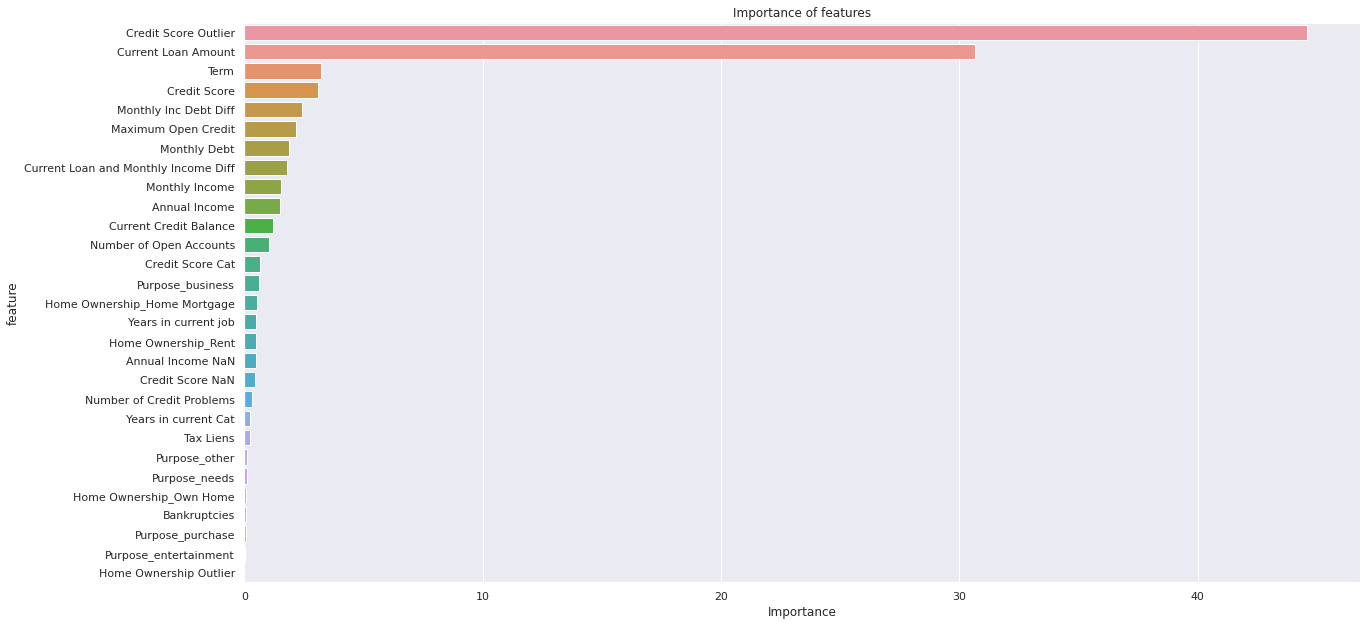

In [145]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=16)

In [146]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Credit Score Outlier,44.593301
8,Current Loan Amount,30.666290
2,Term,3.205049
11,Credit Score,3.090110
27,Monthly Inc Debt Diff,2.395787
5,Maximum Open Credit,2.147407
10,Monthly Debt,1.866109
28,Current Loan and Monthly Income Diff,1.779069
26,Monthly Income,1.529272
0,Annual Income,1.497331


In [147]:
important_features_top

['Credit Score Outlier',
 'Current Loan Amount',
 'Term',
 'Credit Score',
 'Monthly Inc Debt Diff',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan and Monthly Income Diff',
 'Monthly Income',
 'Annual Income',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Credit Score Cat',
 'Purpose_business',
 'Home Ownership_Home Mortgage',
 'Years in current job']

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [148]:
final_model = CatBoostClassifier(learning_rate=0.02, 
                                 max_depth=4, 
                                 n_estimators=500, 
                                 silent=True,
                                 class_weights=[1, disbalance],
                                 random_state=21,
                                #  custom_metric=['Precision', 'Recall'],
                                 eval_metric='F1',
                                 l2_leaf_reg=5)

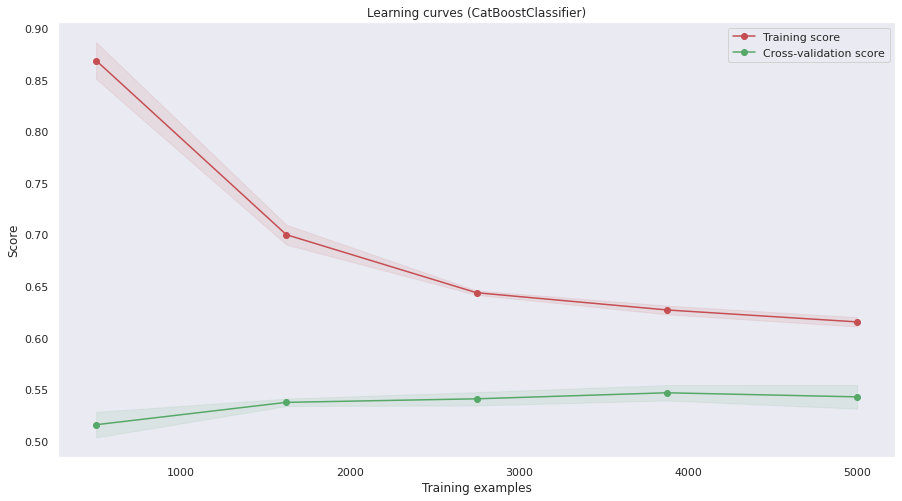

In [149]:
show_learning_curve_plot(final_model, X, y)

Видно, что примерно при размере выборки 4000 экземпляров роста метрики на целевом классе уже не наблюдается.

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

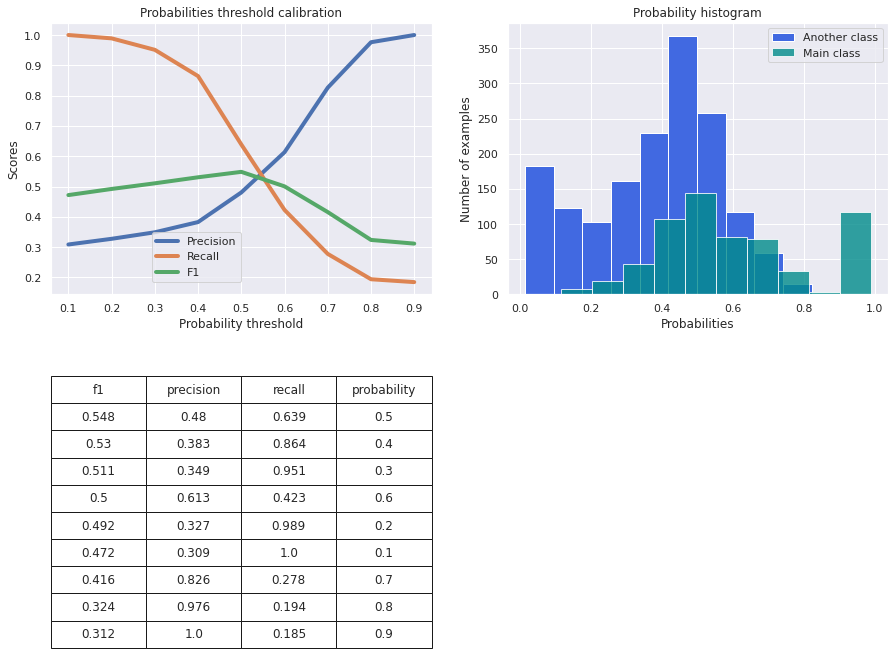

In [150]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)

Оптимальной вероятностью является значение в районе 0,54.

### Финальная модель<a class="anchor" id="final_model"></a>

In [152]:
final_model = CatBoostClassifier(learning_rate=0.02, 
                                 max_depth=4, 
                                 n_estimators=500, 
                                 silent=True,
                                 class_weights=[1, disbalance],
                                 random_state=21,
                                #  custom_metric=['Precision', 'Recall'],
                                 eval_metric='F1',
                                 l2_leaf_reg=10)

final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_valid[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3771
           1       0.54      0.71      0.62      1479

    accuracy                           0.75      5250
   macro avg       0.71      0.74      0.71      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1616
           1       0.48      0.63      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1193  423
1                237  397


# Сделаем предсказания на тестовых данных

In [153]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [154]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


Применяем классы для обработки

In [155]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_test)

df_test = preprocessor.transform(df_test)

# df_prep.columns.to_list()

features_gen = FeatureGenerator()
features_gen.fit(df_test)
features_gen.transform(df_test)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        2500 non-null   object 
 1   Annual Income                         2500 non-null   float64
 2   Years in current job                  2500 non-null   int8   
 3   Tax Liens                             2500 non-null   float64
 4   Number of Open Accounts               2500 non-null   float64
 5   Years of Credit History               2500 non-null   float64
 6   Maximum Open Credit                   2500 non-null   float64
 7   Number of Credit Problems             2500 non-null   float64
 8   Bankruptcies                          2500 non-null   float64
 9   Purpose                               2500 non-null   object 
 10  Term                                  2500 non-null   int64  
 11  Current Loan Amou

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Применяем нормализацию данных

In [156]:
scaler = StandardScaler()

df_test_norm = df_test.copy()
df_test_norm[num_feature_names] = scaler.fit_transform(df_test_norm[num_feature_names])

df = df_test_norm.copy()

In [164]:
# df.head()

In [162]:
predictions = final_model.predict(df[important_features_top])
predictions

array([0, 0, 1, ..., 1, 0, 1])

In [163]:
y_test = pd.DataFrame(predictions, columns=['Credit Default'])
y_test.head()

,Credit Default
0,0
1,0
2,1
3,0
4,0


In [165]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  2500 non-null   int64
dtypes: int64(1)
memory usage: 19.7 KB


In [166]:
y_test['Credit Default'].value_counts()

0    1629
1     871
Name: Credit Default, dtype: int64

In [167]:
y_test.to_csv('INBerezutskiy_predictions.csv', index=None)

# Итерпретация

В ходе EDA были обработаны выбросы и отсутствующие значения. Были созданы классы для обработки данных. Категориальные признаки были частично заменены на числовые. Либо заменены на дамми-переменные. Впрочем, используя catboost можно было подавать на вход модели категориальные признаки как они были изначально. Это тоже давало хорошие результаты.

Была выполнена стандартизация числовых признаков. Лучше всего себя проявил алгоритм бустинга. Был выбран catboost из-за удобной встроенной балансировки классов. Балансировка собственными методами давала результаты, но как мне показалось не совсем оптимальные. Предполагаю, что в данном случае возможно было получить хорошие результаты при балансировке на основе правила Томека.

Изменения l2 для уменьшения переобучения не сильно сказывались на результатах.

В конечном итоге удалось получить F-1 = 0.55 на целевом классе в рамках валидационной проверки. 